# Classification (1) – an issue with distance measures, and an implementation of Nearest Neighbour classification

## Introduction

In this notebook we will expand on some of the concepts of 
classification, starting with an experiment with distance measures on data, then looking into the $k$-Nearest Neighbour algorithm. Please try to understand the code and follow instructions marked in <font color='purple'>purple</font> color.

1) Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclidean distance in 2 and 3-dimensions, there is a problem with high-dimensions –  <font color='purple'>what is this problem</font> ? 

### Pairwise distances in high-dimensional spaces 

 <font color='green'>**Answer**: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative</font>.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now we calculate the pairwise distances among the $N$ points.  After that for every data point we calculate the ratio of the minimum distance to the maximum distance  to all of the other data points. The mean ratio represents the average range of pairwise distances there are in that dimensionality. We run the simulation from 1 dimension to 1000 dimensions and the ratios will be plotted on a line chart using the ``` matplotlib ``` library. 

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate distances such as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

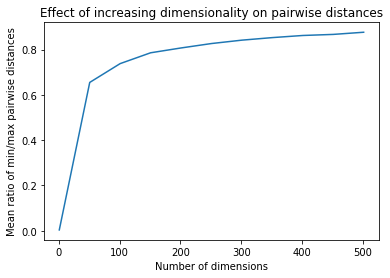

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def run_d_n(dim,N_pts,L):
    pts=np.random.rand(N_pts,dim)-0.5 # simulate N_pts points on dim dimensions space
    ratio_list=[]
    for i in range(N_pts):
        # ignore the data point itself
        selected_pts=np.array([j for j in range(N_pts) if j!=i])
        # calculate the L2 or L1 distance with other points
        dist=np.linalg.norm(pts[selected_pts]-pts[i],L,axis=1)
        # calculate the ratio of the min. distance to the max. distance
        ratio=np.min(dist)/np.max(dist)
        ratio_list.append(ratio)
    # output the mean ratio
    return np.mean(ratio_list)

# Initialise the N_pts, the number of points we simulate
N_pts=200
# Setting l=2 to calculate the L2 distance
l=2
# Setting the number of dimensions we simulate
check_dim=range(1,550,50)
# Calculate the mean ratio on that dimension
ratio_list=[ run_d_n(dim,N_pts,l) for dim in check_dim]
# Plot the ratio with its corresponding dimension
plt.plot(check_dim,ratio_list)
plt.ylabel("Mean ratio of min/max pairwise distances")
plt.xlabel("Number of dimensions")
plt.title("Effect of increasing dimensionality on pairwise distances")
plt.xticks(np.arange(0, 600, step=100))
plt.show()

 <font color='purple'>**Question:** how can this plot be interpreted ? How else could you visualize this effect</font> ?

<font color='green'>We can interpret this as showing that as dimensionality increases the min. and max. distances from any point to any other point become more similar. Something this plot doesn't show is the  distribution of the actual distances. To see this, you could try plotting histograms of the distribution of all pairwise distances for a set of points of low, then higher dimensionality. If you do this, first think about how you would expect it to look. We can also visualize this effect using, for example, histogram as shown below<font>

11

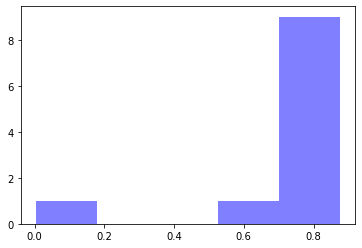

In [5]:
num_bins = 5
# x = np.random.randn(100)
n, bins, patches = plt.hist(ratio_list, num_bins, facecolor='blue', alpha=0.5)
len(ratio_list)
# the histogram shows how many ratios from ratio list are in each bin range by dividing (max-min)/num_bins

## 2) Implement Nearest Neighbour from scratch

The following will give some practise in implementing a simple classifier, the $k$-Nearest Neighbour ($k$NN) algorithm. It should help us to write a $k$NN package from scratch. Most machine learning methods include two main steps, namely training (fitting to a model to the training data) and prediction (running the model on input data  to generate output). However, in the $k$NN algorithm, since there is no explicit model-building step, we only require implementation of the prediction step without a training step.

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Creation

In [7]:
mean_01 = np.array([1, 0.5])
cov_01 = np.array([[1, 0.1], [0.1, 1.2]])

mean_02 = np.array([4, 5])
cov_02 = np.array([[1, 0.1], [0.1, 1.2]])

dist_01 = np.random.multivariate_normal(mean_01, cov_01, 500)
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 500)
print(dist_01.shape, dist_02.shape)

(500, 2) (500, 2)


We have created two 2-dimensional normal distributions of data points with the same covariance but different means.

## Plotting the created Data 

<font color='purple'>What does the data look like ? Notice the 2 unique clusters being formed.</font>

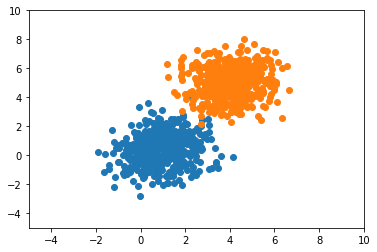

In [8]:
plt.figure(0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.scatter(dist_01[:, 0], dist_01[:, 1])
plt.scatter(dist_02[:, 0], dist_02[:, 1])#, color='red')
plt.show()

Let us now represent it in a tabular way. We will have dist_01 getting label 1.

In [9]:
r = dist_01.shape[0] + dist_02.shape[0]
c = dist_01.shape[1] + 1
data = np.zeros((r, c))
print(data.shape)

data[:dist_01.shape[0], :2] = dist_01
data[dist_01.shape[0]:, :2] = dist_02
data[dist_01.shape[0]:, -1] = 1.0

print(data.mean(axis=0))

(1000, 3)
[2.48556012 2.72797566 0.5       ]


Now shuffle the data and check by printing the first 10 rows.

In [10]:
np.random.shuffle(data)
print(data[:10])

[[ 3.63426796  4.35555546  1.        ]
 [ 0.24052683  1.01102891  0.        ]
 [-1.42947553 -0.91413326  0.        ]
 [ 0.49553387  0.0078872   0.        ]
 [ 3.15040842  1.11657911  0.        ]
 [ 3.53136065  6.08213792  1.        ]
 [ 0.49659912  0.84287202  0.        ]
 [ 2.01100085  2.24584409  0.        ]
 [ 4.19715708  5.62356862  1.        ]
 [ 2.02770584  3.88377923  1.        ]]


**Implementation.** Next, we implement our KNN algorithm. There are many ways to do this, but a basic approach will require a pairwise distance measure for instances, and a way to take a "training" dataset of classified instances and make a prediction for a "test" data instance. Here is a top-level outline.

<font color='purple'>Please add an impelemtation code. Use Manhattan (L2) distance</font>.

In [11]:
def distance(x1, x2):
    d = np.sqrt(((x1-x2)**2).sum())
    # using linarg.norm function is an alternative way to implement the distance
#     d = np.linalg.norm(x1-x2,2)
    return d

# xt is the point we want to test
def knn(X_train, y_train, xt, k=7):
    vals = []
    for ix in range(X_train.shape[0]): # num rows
        d = distance(X_train[ix], xt) # distances of all training points from xt
        vals.append([d, y_train[ix]]) #dist, y values
    # sorted labels has two cols: dist and class of each point that dist was calculated
    sorted_labels = sorted(vals, key=lambda z: z[0]) # sort by dist, first val, second would be z[1], which is y value
    neighbours = np.asarray(sorted_labels)[:k, -1] # take k rows of last col (y val)
    
    # count of each val Y, there are two vals 0 amd 1
    freq = np.unique(neighbours, return_counts=True) 
    # freq[0] has class values: 0 amd 1, freq[1] has num of votes for 0 and for 1
    # return row 0 and col that has max count (freq is a tuple of arrays)
    # argmax returns col of freq[1] that has higher count, so freq[0] takes class from that col
    return freq[0][freq[1].argmax()] # return y: 0 or 1, whichever got higher count

<font color='purple'>Now check to see if we can make a prediction</font>.

In [12]:
test_point = np.array([8, -4])

# Un-comment the line below and check if it comes out as 0.0  
print(knn(data[:, :2], data[:, -1], test_point))

0.0


## Create a train and test split of the data

In [13]:
np.random.shuffle(data)
split = int(0.75 * data.shape[0])
# print split
train_data_X = data[:split, :2]
train_data_y = data[:split, -1]
test_data_X = data[split:, :2]
test_data_y = data[split:, -1]

print(train_data_X.shape, train_data_y.shape)
print(test_data_X.shape, test_data_y.shape)

(750, 2) (750,)
(250, 2) (250,)


<font color='purple'>**Implementation.** Next, please add an implementation to run our KNN classifier on all the test data and get the results</font>. 

In [14]:
# kx is the number of neighbours
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(test_data_X.shape[0]):
        preds.append(knn(train_data_X, train_data_y, test_data_X[ix], k=kx))
    preds = np.asarray(preds)
    
    # print preds.shape (if test_data_y is pred, then 1, sums of 1 is num correct)
    return 100*float((test_data_y == preds).sum())/preds.shape[0] # number of instances

print(get_acc(7))

100.0


<font color='purple'>What accuracy did you get ? You should get around 99 percent on this dataset</font>. 

## Now let's try real data : MNIST

In [15]:
import pandas as pd
import datetime

Of course, MNIST is image data, but here we are using a CSV version where we can view the pixels as numbers (each row has the pixel data for an image of a digit, and the first column is the class of the digit, i.e., 0-9).

In [16]:
df = pd.read_csv('train.csv')
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset is quite big, we will just use a subset.

In [17]:
data = df.values[:2000]
print (data.shape)

(2000, 785)


Make a train/test split of the data.

In [18]:
split = int(0.8 * data.shape[0])

X_train = data[:split, 1:]
X_test = data[split:, 1:]
y_train = data[:split, 0]
y_test = data[split:, 0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 784) (1600,)
(400, 784) (400,)


Let us just check that our data really does represent images.

4


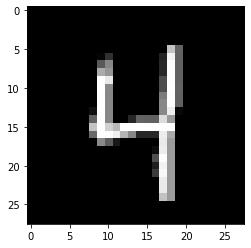

In [19]:
plt.figure(0)
plt.imshow(X_train[91].reshape((28, 28)), cmap='gray', interpolation='none')
print (y_train[91])
plt.show()

<font color='purple'>**Implementation.** Now code another ```get_acc()``` and try different values of K on our dataset</font>.

In [17]:
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(X_test.shape[0]):
        start = datetime.datetime.now()
        preds.append(knn(X_train, y_train, X_test[ix], k=kx))
    preds = np.asarray(preds)
    
    # print preds.shape
    return 100*float((y_test == preds).sum())/preds.shape[0]

print("Result: ")
print(get_acc(5))  # k=?


Result: 
89.25


<font color='purple'>Try different values of k and observe how the results change. Which k gives the best result and why?</font>.
<br>
<font color='green'>For this dataset, the best accuracy is for k=1 because the digit images in training and test sets are very similar and the first neighbour give an accurate prediction. </font>.
<br>
<font color='purple'>Now explore different metrics: precision, recall, F1 and confusion matrix. Use ```sklearn.neighbors KNeighborsClassifier``` to obtain predictions and ```sklearn.metrics``` to do the calculations. Notice a high number of instaces on the diagonal.</font>

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Precision: "+str(precision_score(y_test, y_pred, average='micro')))
print("Recall: "+str(recall_score(y_test, y_pred, average='micro')))
print("F1: "+str(f1_score(y_test, y_pred, average='micro')))
print("Confusion_matrix: \n"+str(confusion_matrix(y_test, y_pred)))

Precision: 0.8775
Recall: 0.8775
F1: 0.8775
Confusion_matrix: 
[[39  0  0  1  0  0  1  0  0  0]
 [ 0 50  0  0  0  1  0  0  0  0]
 [ 0  5 36  1  0  0  0  2  0  0]
 [ 0  0  1 40  0  1  1  2  0  1]
 [ 0  4  0  0 28  0  1  0  0  0]
 [ 0  0  0  4  1 23  0  0  0  0]
 [ 0  1  0  0  0  0 34  0  0  0]
 [ 1  2  0  0  1  0  0 54  0  5]
 [ 0  1  0  3  0  4  0  0 20  0]
 [ 0  1  0  1  2  0  0  0  0 27]]
